In [1]:
# Adapted from: https://github.com/crispitagorico/Hall-areas/blob/master/Sig-inversion%20through%20Legendre%20polynomials.ipynb
import numpy as np
import math
from math import gamma
from scipy.integrate import quad
import matplotlib.pyplot as plt
from free_lie_algebra import *
from abc import ABC, abstractmethod

In [2]:
class Orthogonal_poly(ABC):
    def __init__(self, x1=-1, x2=1):
        self.x1 = x1
        self.x2 = x2
        self.weight = lambda t: 1

    @abstractmethod
    def P(self, n):
        pass

    @abstractmethod
    def ortho_factor(self, n):
        pass

    @abstractmethod
    def recurrence(self, n):
        pass

    def a(self, x, n):
        P_n = self.P(n)
        snorm_n = self.ortho_factor(n)
        return quad(lambda t: x(t)*P_n(t)*self.weight(t), self.x1, self.x2)[0]/snorm_n

    def l(self, n):
        if n==0:
            A0 = self.recurrence(n)
            s_norm0 = self.ortho_factor(n)
            return A0 / s_norm0 * word2Elt('21') 
        elif n==1:
            A1, B1 = self.recurrence(n)
            s_norm1 = self.ortho_factor(n)
            return (A1*self.x1+B1)/(s_norm1)*word2Elt('21') + A1/s_norm1*(word2Elt('211')+word2Elt('121'))
        else:
            An, Bn, Cn = self.recurrence(n)
            snorm_n = self.ortho_factor(n)
            snorm_n1 = self.ortho_factor(n-1)
            snorm_n2 = self.ortho_factor(n-2)
            l_prev = self.l(n-1)
            l_prev_prev = self.l(n-2)
            l_n = An*snorm_n1/snorm_n*rightHalfShuffleProduct(word2Elt('1'),l_prev)\
                  + (An*self.x1+Bn)*snorm_n1/snorm_n*l_prev\
                  + Cn*snorm_n2/snorm_n*l_prev_prev
            return l_n

    def a_sig(self, sig, n):
        return dotprod(self.l(n), sig)

    def sig2path(self, sig, N, t_grid):
        sig_map =  lambda t: sum([self.a_sig(sig, n)*self.P(n)(t) for n in range(N+1)])
        return sig_map(t_grid) / self.weight(t_grid)

    def ploy2path(self, x, N, t_grid):
        poly_map = lambda t: sum([self.a(x, n)*self.P(n)(t) for n in range(N+1)])
        return poly_map(t_grid)


class Legendre(Orthogonal_poly):
    def __init__(self):
        super().__init__(-1, 1)
        self.weight = lambda t: 1

    def P(self, n):
        return lambda t: sum([math.comb(n, m)*math.comb(n+m, m)*(-t)**m for m in range(n+1)])

    def ortho_factor(self, n):
        return 2 / (2*n+1)

    def recurrence(self, n):
        if n==0:
            return 1
        elif n==1:
            return 1, 0
        else:
            An = (2*n+1) / (n+1)
            Bn = 0
            Cn = -n / (n+1)
            return An, Bn, Cn

class Jacobi(Orthogonal_poly):
    def __init__(self, alpha, beta):
        super().__init__(-1, 1)
        if alpha<0 or beta<0:
            raise ValueError('Alpha and beta must be both non negative!')
        self.alpha = alpha
        self.beta = beta
        self.weight = lambda t: (1-t)**alpha*(1+t)**beta

    def P(self, n):
        a = self.alpha
        b = self.beta
        factor = gamma(a+n+1) / math.factorial(n) / gamma(a+b+n+1)
        return lambda t: factor * sum([math.comb(n, m)*gamma(a+b+n+m+1)/gamma(a+m+1)*((t-1)/2)**m for m in range(n+1)])

    def ortho_factor(self, n):
        a = self.alpha
        b = self.beta
        return 2**(a+b+1) * gamma(n+a+1) * gamma(n+b+1) / (2*n+a+b+1) / gamma(n+a+b+1) / math.factorial(n)

    def recurrence(self, n):
        a = self.alpha
        b = self.beta
        if n == 0:
            return 1
        elif n==1:
            A1 = (a+b+2) / 2
            B1 = (a+1) - A1
            return A1, B1
        else:
            x = n + a
            y = n + b
            z = x + y
            denominator = 2 * n * (z-n) * (z-2)
            An = z * (z-1) * (z-2) / denominator
            Bn = (z-1) * (x-y) * (z-2*n) / denominator
            Cn = - 2 * (x-1) * (y-1) * z / denominator
            # P = self.P
            # grid = np.random.uniform(-1, 1, 30)
            # assert(np.linalg.norm(P(n)(grid)-(An*grid+Bn)*P(n-1)(grid)-Cn*P(n-2)(grid))<1.0e-6)
            return An , Bn, Cn

In [3]:
length = 200
t_grid = np.linspace(-1, 1, length)

In [4]:
def x_(t):
    return np.cos(15*t) - np.sin(3*t)
def x(t):
    return x_(t) - x_(-1)

N = 15
trunc_sig = N + 2

poly = Jacobi(0, 0)
path_poly = poly.ploy2path(x, N, t_grid)

path = x(t_grid)
path_time = np.c_[t_grid, path*poly.weight(t_grid)]

sig = signature_of_path_iisignature(path_time, trunc_sig)

path_sig = poly.sig2path(sig, N, t_grid)

C:\Users\Besty\AppData\Local\Temp\ipykernel_95112\3213208712.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(lambda t: x(t)*P_n(t)*self.weight(t), self.x1, self.x2)[0]/snorm_n


In [5]:
for n in range(N):
    print((poly.a_sig(sig, n)-poly.a(x, n))**2)

6.746337870057736e-09
6.171997052327427e-09
9.572976241999886e-08
6.499871427520092e-09
2.030736002265079e-09
1.8696004662564683e-10
1.2649913306363626e-06
8.609222862120209e-13
5.362332855986881e-06
1.6096404346503577e-15
4.990371757356965e-09
2.1260944570132225e-15
1.704763611326626e-05
2.5397738068109805e-12
1.4640030668296967e-05


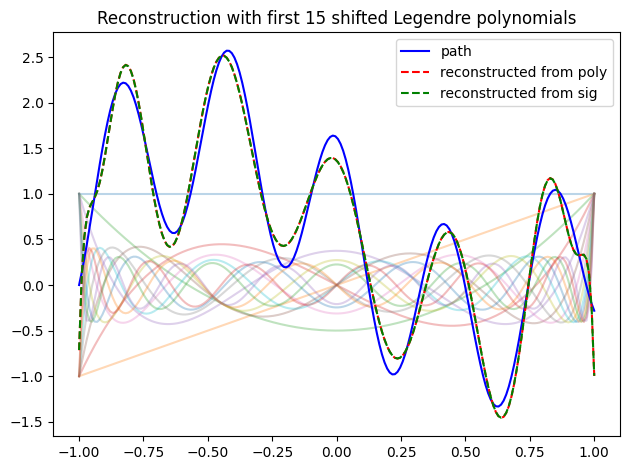

In [6]:
for n in range(N):
    plt.plot(t_grid, poly.P(n)(t_grid), alpha=0.3)
plt.plot(t_grid, path, label='path', c='blue')
plt.plot(t_grid, path_poly, label='reconstructed from poly', c='red', linestyle='--')
plt.plot(t_grid, path_sig, label='reconstructed from sig', c='g', linestyle='--')
plt.legend()
plt.title(f'Reconstruction with first {N} shifted Legendre polynomials')
plt.tight_layout()

In [11]:
def x_(t):
    return np.cos(35*t) - np.sin(5*t)
def x(t):
    return x_(t) - x_(-1)

N = 15
trunc_sig = N + 2

poly = Jacobi(0, 0)
path_poly = poly.ploy2path(x, N, t_grid)

path = x(t_grid)
path_time = np.c_[t_grid, path*poly.weight(t_grid)]

sig = signature_of_path_iisignature(path_time, trunc_sig)

path_sig = poly.sig2path(sig, N, t_grid)

C:\Users\Besty\AppData\Local\Temp\ipykernel_95112\3213208712.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(lambda t: x(t)*P_n(t)*self.weight(t), self.x1, self.x2)[0]/snorm_n


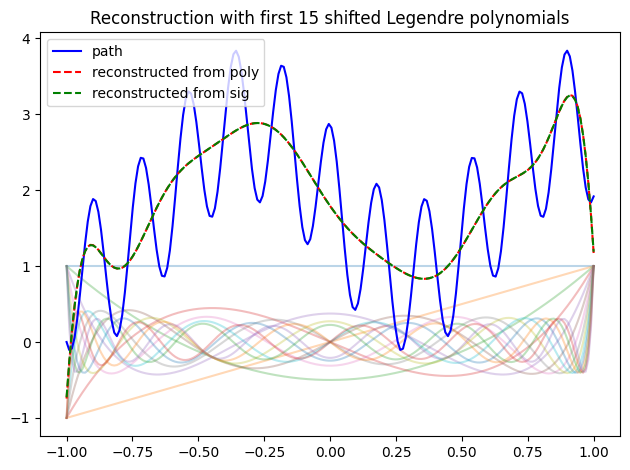

In [12]:
for n in range(N):
    plt.plot(t_grid, poly.P(n)(t_grid), alpha=0.3)
plt.plot(t_grid, path, label='path', c='blue')
plt.plot(t_grid, path_poly, label='reconstructed from poly', c='red', linestyle='--')
plt.plot(t_grid, path_sig, label='reconstructed from sig', c='g', linestyle='--')
plt.legend()
plt.title(f'Reconstruction with first {N} shifted Legendre polynomials')
plt.tight_layout()